# Model analysis

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
with open('../group.json') as f:
    data = json.load(f)
    ocrnet = pd.DataFrame(data['ocrnet'])
    pointrend = pd.DataFrame(data['point_rend'])
    dmnet = pd.DataFrame(data['dmnet'])
    
df = pd.concat([ocrnet, pointrend, dmnet])

In [3]:
df.head()

,network,backbone,pretrained,aAcc,mDice,mAcc,data_time,time,step
0,OCRNet,HRNet,ade,85.19,8.24,9.31,0.033609,0.086956,1
1,OCRNet,HRNet,ade,89.88,9.76,9.08,0.017576,0.071249,2
2,OCRNet,HRNet,cityscapes,88.52,6.96,6.85,0.032560,0.137402,1
3,OCRNet,HRNet,cityscapes,89.25,7.23,6.72,0.046495,0.164720,2
4,OCRNet,Resnet,cityscapes,87.84,8.88,9.09,0.032881,0.097223,1


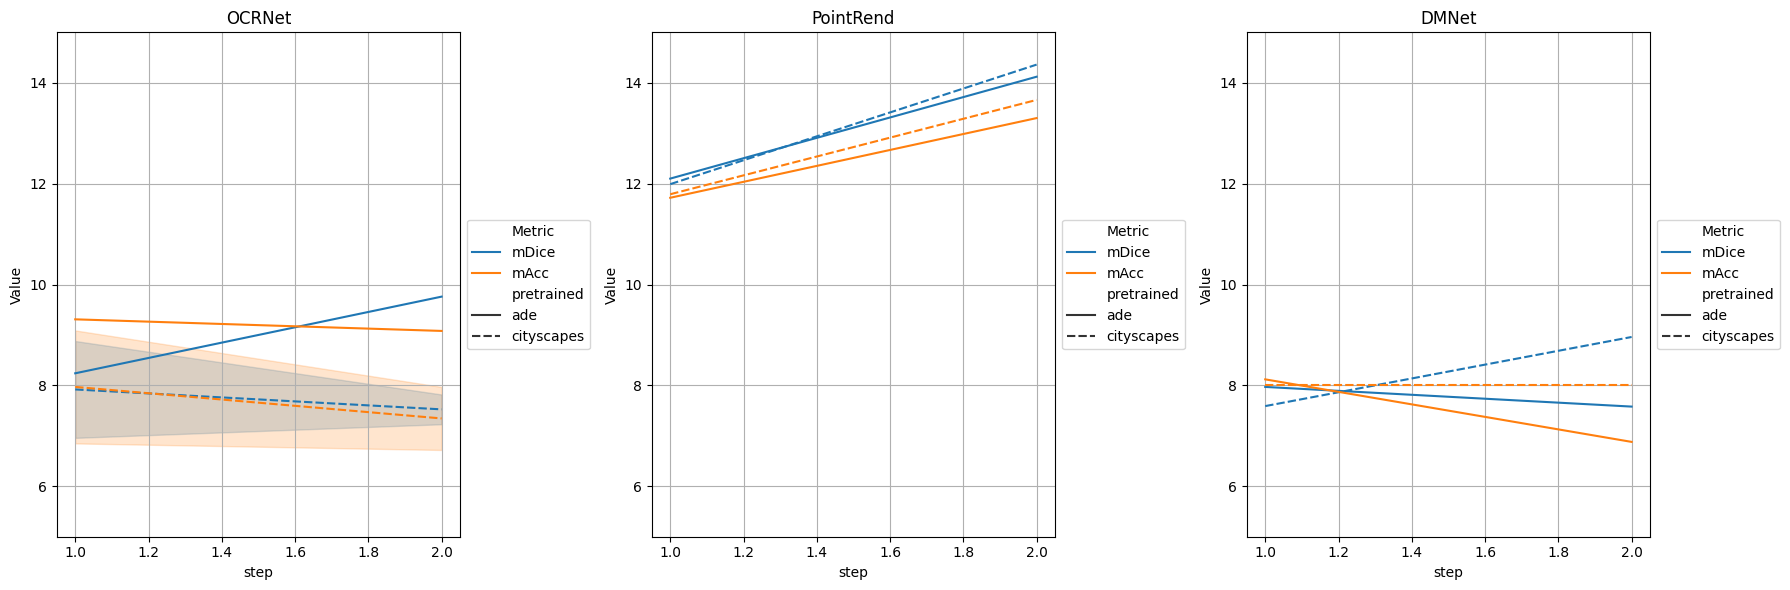

In [17]:
# Assuming you have already imported ocrnet, pointrend, and dmnet dataframes

# Melt the dataframes
ocrnet_melted = pd.melt(ocrnet, id_vars=['step', 'pretrained'], value_vars=['mDice', 'mAcc'], var_name='Metric', value_name='Value')
pointrend_melted = pd.melt(pointrend, id_vars=['step', 'pretrained'], value_vars=['mDice', 'mAcc'], var_name='Metric', value_name='Value')
dmnet_melted = pd.melt(dmnet, id_vars=['step', 'pretrained'], value_vars=['mDice', 'mAcc'], var_name='Metric', value_name='Value')

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot using Seaborn
sns.lineplot(data=ocrnet_melted, x='step', y='Value', hue='Metric', style="pretrained", ax=ax[0])
ax[0].set_title("OCRNet")
ax[0].set_ylim(5, 15)
ax[0].grid()

sns.lineplot(data=pointrend_melted, x='step', y='Value', hue='Metric', style="pretrained", ax=ax[1])
ax[1].set_title("PointRend")
ax[1].set_ylim(5, 15)
ax[1].grid()

sns.lineplot(data=dmnet_melted, x='step', y='Value', hue='Metric', style="pretrained", ax=ax[2])
ax[2].set_title("DMNet")
ax[2].set_ylim(5, 15)
ax[2].grid()

# Adjust legend
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show plot
plt.tight_layout()
plt.show()


# Batch size Analysis

In [5]:
with open('../group_batchsize.json') as f:
    data = json.load(f)

In [6]:
# Create an empty list to store data for the dataframe
df_list = []

# Loop through each key (batchsize) in the JSON data
for key, value in data.items():
  # For each value (list of dictionaries), append dictionaries with an extra column 'batchsize' set to the key
  for item in value:
    item['batchsize'] = key
    df_list.append(item)

# Create the dataframe from the list
df = pd.DataFrame(df_list)

# Print the dataframe
df.head()

,aAcc,mDice,mAcc,data_time,time,step,batchsize
0,91.11,12.10,11.72,0.018081,0.054526,1,2
1,91.82,14.12,13.30,0.016509,0.053082,2,2
2,92.04,16.11,15.22,0.033557,0.095723,3,2
3,92.09,15.72,14.74,0.016858,0.054110,4,2
4,91.14,12.15,11.11,0.014900,0.037200,1,4


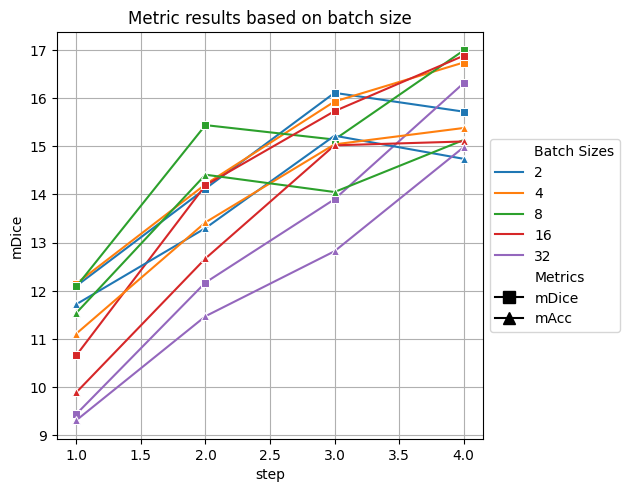

In [11]:
# Define the metrics you want to plot (replace with your desired columns)
metrics = ['mDice', 'mAcc']

marker_styles = {'mDice': 's', 'mAcc': '^'}

# Create a subplot for each metric

for metric, marker in zip(metrics, marker_styles.values()):
  sns.lineplot(x='step', y=metric, marker=marker, hue='batchsize', data=df)
  
# Create a custom legend
handles = []
labels = []
batch_sizes_seen = set()
handles.append(plt.Line2D([], [], color='black', marker='', linestyle='None', label='Batch Sizes'))
labels.append('Batch Sizes')
# Add batch sizes with colors to the legend
for batch_size, color in zip(df['batchsize'].unique(), sns.color_palette()):
    handles.append(plt.Line2D([], [], color=color, markersize=8, linestyle='-', label=batch_size))
    labels.append(batch_size)
    
handles.append(plt.Line2D([], [], color='black', marker='', linestyle='None', label='Metrics'))
labels.append('Metrics')
for batch_size, marker in marker_styles.items():
    if batch_size in batch_sizes_seen:
        continue
    handles.append(plt.Line2D([], [], color='black', marker=marker, markersize=8, linestyle='-'))
    labels.append(batch_size)
    batch_sizes_seen.add(batch_size)

plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.title("Metric results based on batch size")
plt.grid()
plt.show()

# Image resolution

In [4]:
with open('../group_imageres.json') as f:
    data = json.load(f)

In [5]:
# Create an empty list to store data for the dataframe
df_list = []

# Loop through each key (batchsize) in the JSON data
for key, value in data.items():
  # For each value (list of dictionaries), append dictionaries with an extra column 'batchsize' set to the key
  for item in value:
    item['image_resolution'] = key
    df_list.append(item)

# Create the dataframe from the list
df = pd.DataFrame(df_list)

# Print the dataframe
df.head()

,aAcc,mDice,mAcc,data_time,time,step,image_resolution
0,91.70,12.09,11.54,0.026481,0.066416,1,192
1,92.20,15.44,14.41,0.014905,0.037172,2,192
2,92.52,15.14,14.05,0.014613,0.036997,3,192
3,92.66,16.99,15.13,0.014726,0.037496,4,192
4,92.79,16.27,14.93,0.023043,0.139905,1,384


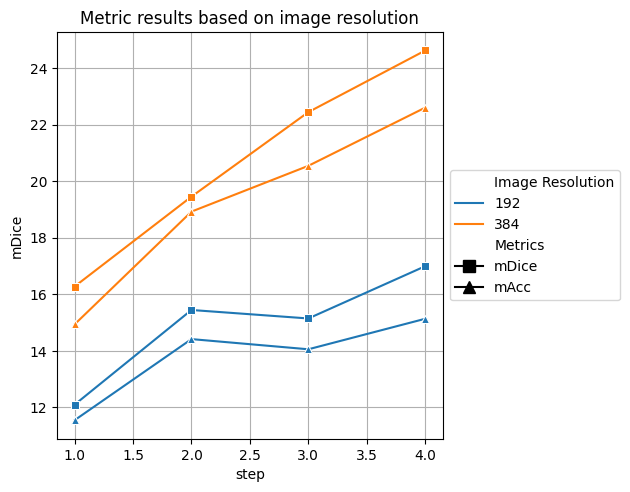

In [6]:
# Define the metrics you want to plot (replace with your desired columns)
metrics = ['mDice', 'mAcc']

marker_styles = {'mDice': 's', 'mAcc': '^'}

# Create a subplot for each metric

for metric, marker in zip(metrics, marker_styles.values()):
  sns.lineplot(x='step', y=metric, marker=marker, hue='image_resolution', data=df)
  
# Create a custom legend
handles = []
labels = []
batch_sizes_seen = set()
handles.append(plt.Line2D([], [], color='black', marker='', linestyle='None', label='Image Resolution'))
labels.append('Image Resolution')
# Add batch sizes with colors to the legend
for batch_size, color in zip(df['image_resolution'].unique(), sns.color_palette()):
    handles.append(plt.Line2D([], [], color=color, markersize=8, linestyle='-', label=batch_size))
    labels.append(batch_size)
    
handles.append(plt.Line2D([], [], color='black', marker='', linestyle='None', label='Metrics'))
labels.append('Metrics')
for batch_size, marker in marker_styles.items():
    if batch_size in batch_sizes_seen:
        continue
    handles.append(plt.Line2D([], [], color='black', marker=marker, markersize=8, linestyle='-'))
    labels.append(batch_size)
    batch_sizes_seen.add(batch_size)

plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.title("Metric results based on image resolution")
plt.grid()
plt.show()

In [33]:
classes = []
dice_scores = []
accuracy_scores = []

# Open the .log file
with open('../pointrend_8bs.log', 'r') as file:
    # Read lines from the file in reverse order
    lines = file.readlines()[::-1]
    found_last_validation = False
    for line in lines:
        # Check if the line indicates the start of the last validation section
        if 'Epoch(val) [4]' in line:
            found_last_validation = True
            continue
        # If the last validation section from the 4th epoch is found, extract data
        if found_last_validation:
            # Use regular expressions to extract class names, dice scores, and accuracy scores
            match = re.match(r'\|\s+(\w[\w\s,]+)\s+\|\s+([\d.]+)\s+\|\s+([\d.]+)\s+\|', line)
            if match:
                class_name = match.group(1).strip()
                dice_score = float(match.group(2))
                accuracy_score = float(match.group(3))
                classes.append(class_name)
                dice_scores.append(dice_score)
                accuracy_scores.append(accuracy_score)
            # Check if the end of the last validation section is reached
            if 'per class results:' in line:
                break

# Create a DataFrame from the extracted data
data = {'Class': classes, 'Dice': dice_scores, 'Acc': accuracy_scores}
df_192 = pd.DataFrame(data)

In [43]:
df_192.head()

,Class,Dice,Acc
0,tassel,0.00,0.00
1,sequin,0.00,0.00
2,ruffle,8.86,4.64
3,rivet,0.00,0.00
4,ribbon,0.00,0.00


In [38]:
classes = []
dice_scores = []
accuracy_scores = []

# Open the .log file
with open('../pointrend_4epoch_8bs_384ir.log', 'r') as file:
    # Read lines from the file in reverse order
    lines = file.readlines()[::-1]
    found_last_validation = False
    for line in lines:
        # Check if the line indicates the start of the last validation section
        if 'Epoch(val) [4]' in line:
            found_last_validation = True
            continue
        # If the last validation section from the 4th epoch is found, extract data
        if found_last_validation:
            # Use regular expressions to extract class names, dice scores, and accuracy scores
            match = re.match(r'\|\s+(\w[\w\s,]+)\s+\|\s+([\d.]+)\s+\|\s+([\d.]+)\s+\|', line)
            if match:
                class_name = match.group(1).strip()
                dice_score = float(match.group(2))
                accuracy_score = float(match.group(3))
                classes.append(class_name)
                dice_scores.append(dice_score)
                accuracy_scores.append(accuracy_score)
            # Check if the end of the last validation section is reached
            if 'per class results:' in line:
                break

# Create a DataFrame from the extracted data
data = {'Class': classes, 'Dice': dice_scores, 'Acc': accuracy_scores}
df_384 = pd.DataFrame(data)

In [42]:
df_384.head()

,Class,Dice,Acc
0,tassel,0.00,0.00
1,sequin,0.00,0.00
2,ruffle,22.14,12.71
3,rivet,0.00,0.00
4,ribbon,0.00,0.00


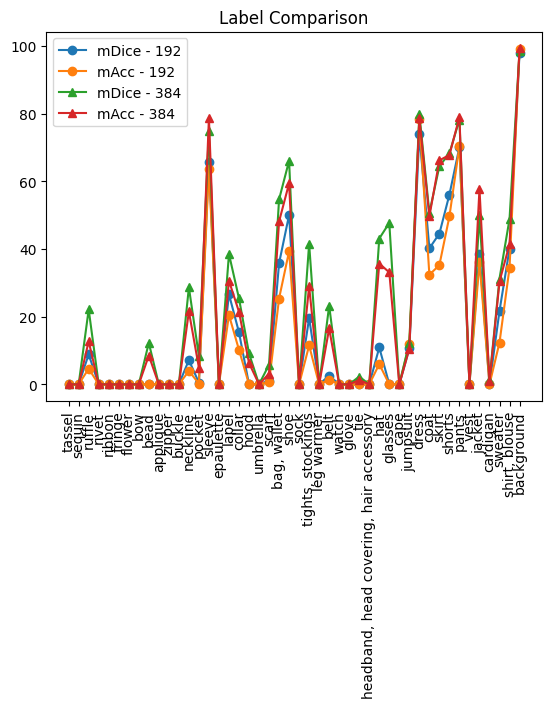

In [51]:
plt.plot(df_192['Class'],df_192['Dice'], label="mDice - 192", marker="o")
plt.plot(df_192['Class'],df_192['Acc'], label="mAcc - 192", marker="o")
plt.plot(df_384['Class'],df_384['Dice'], label="mDice - 384", marker="^")
plt.plot(df_384['Class'],df_384['Acc'], label="mAcc - 384", marker="^")

plt.xticks(rotation=90)
plt.title("Label Comparison")
plt.legend()
plt.show()

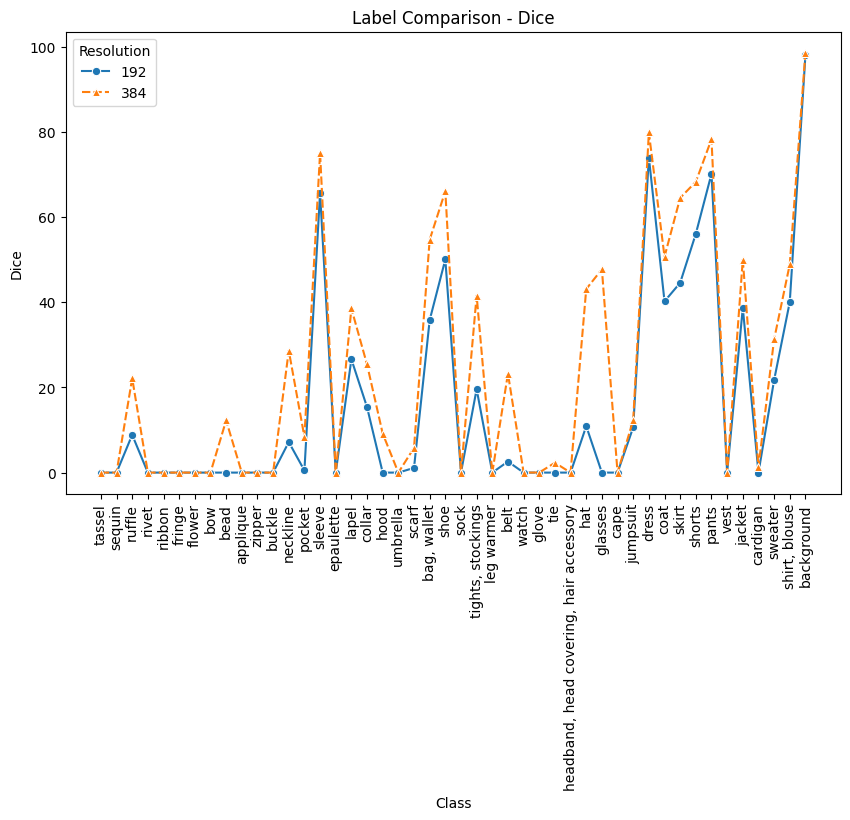

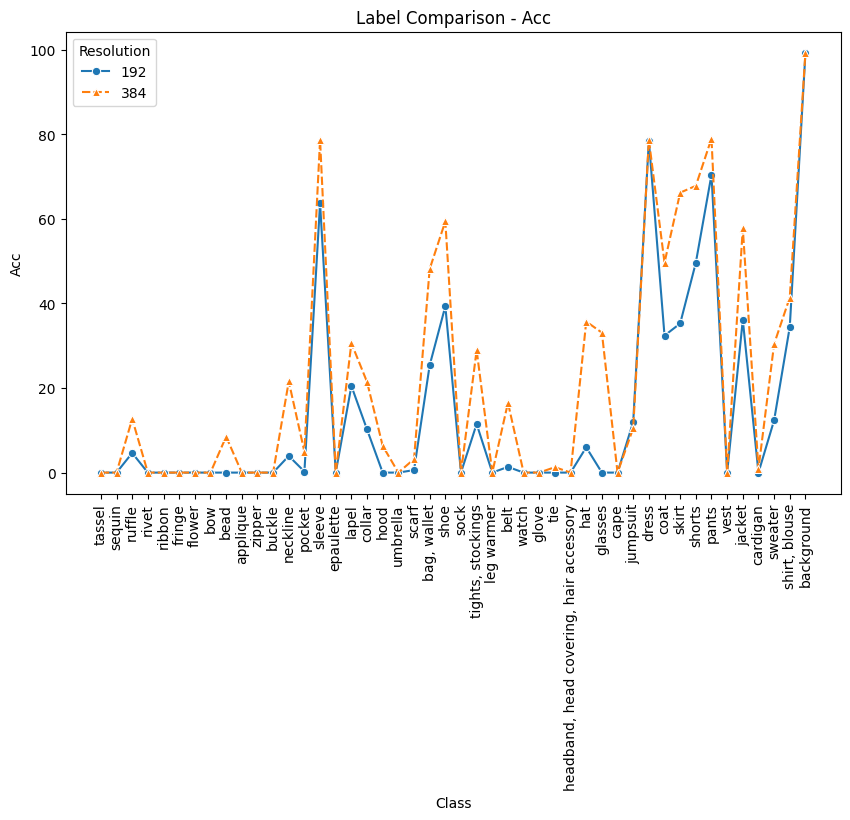

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for each dataset with appropriate labels
df_192['Resolution'] = '192'
df_192['Metric'] = 'Dice'
df_384['Resolution'] = '384'
df_384['Metric'] = 'Dice'
df_acc_192 = df_192.copy()
df_acc_192['Metric'] = 'Acc'
df_acc_384 = df_384.copy()
df_acc_384['Metric'] = 'Acc'

# Concatenate the DataFrames
df_concat = pd.concat([df_192, df_acc_192, df_384, df_acc_384])

# Plot 'Dice' using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_concat[df_concat['Metric'] == 'Dice'], x='Class', y='Dice', hue='Resolution', style='Resolution', markers={'192': 'o', '384': '^'})
plt.xticks(rotation=90)
plt.title("Label Comparison - Dice")
plt.legend(title='Resolution')
plt.show()

# Plot 'Acc' using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_concat[df_concat['Metric'] == 'Acc'], x='Class', y='Acc', hue='Resolution', style='Resolution', markers={'192': 'o', '384': '^'})
plt.xticks(rotation=90)
plt.title("Label Comparison - Acc")
plt.legend(title='Resolution')
plt.show()



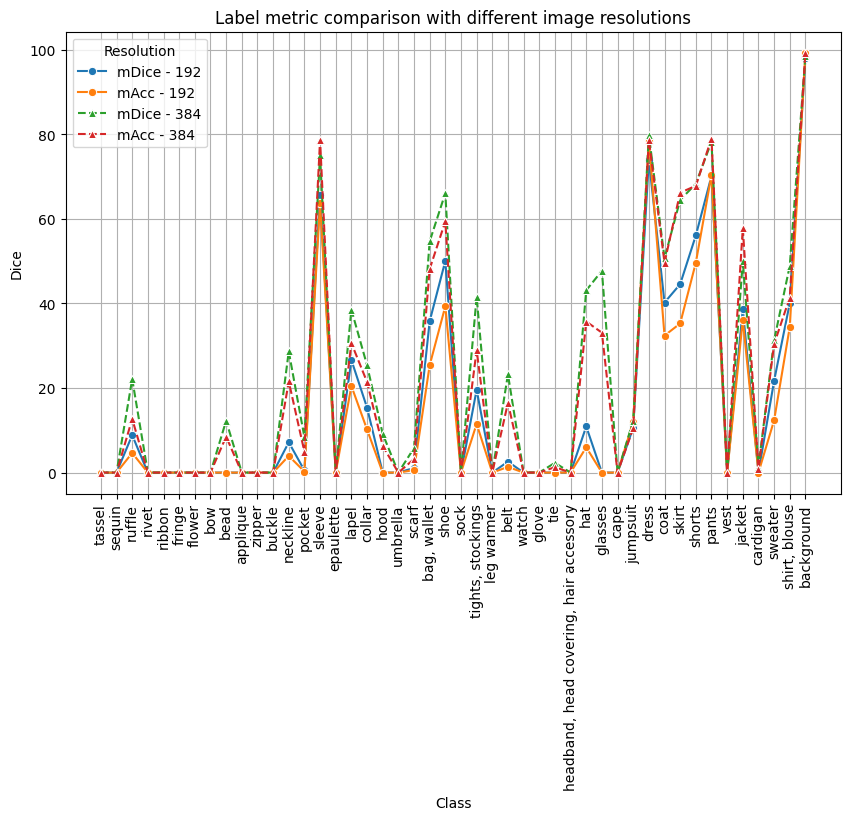

In [81]:
# Plot 'Dice' using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_192, x='Class', y='Dice', label='mDice - 192', marker='o')
sns.lineplot(data=df_192, x='Class', y='Acc', label='mAcc - 192', marker='o')


# Plot 'Acc' using Seaborn
sns.lineplot(data=df_384, x='Class', y='Dice', label='mDice - 384', marker='^', linestyle='--')
sns.lineplot(data=df_384, x='Class', y='Acc', label='mAcc - 384', marker='^', linestyle='--')

plt.xticks(rotation=90)
plt.title("Label metric comparison with different image resolutions")
plt.legend(title='Resolution')
plt.grid()
plt.show()

In [71]:
df_concat

,Class,Dice,Acc,Resolution,Metric,Value
0,tassel,0.00,0.00,192,Dice,0.00
1,sequin,0.00,0.00,192,Dice,0.00
2,ruffle,8.86,4.64,192,Dice,8.86
3,rivet,0.00,0.00,192,Dice,0.00
4,ribbon,0.00,0.00,192,Dice,0.00
...,...,...,...,...,...,...
41,jacket,50.02,57.78,384,Acc,57.78
42,cardigan,1.32,0.87,384,Acc,0.87
43,sweater,31.29,30.41,384,Acc,30.41
44,"shirt, blouse",48.90,41.41,384,Acc,41.41
